In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D,Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import numpy as np

In [62]:
import os
import shutil
from sklearn.model_selection import train_test_split

def redistribute_images(source_dir, train_dir, val_dir, test_size=0.2):
    # Create directories if they do not exist
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)

    # List classes and distribute files
    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    for cls in classes:
        class_dir = os.path.join(source_dir, cls)
        files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

        # Split files into training and validation
        train_files, val_files = train_test_split(files, test_size=test_size, random_state=42)

        # Function to move files to their new directory
        def move_files(files, dest):
            os.makedirs(os.path.join(dest, cls), exist_ok=True)
            for f in files:
                shutil.move(f, os.path.join(dest, cls, os.path.basename(f)))

        # Move files to respective directories
        move_files(train_files, train_dir)
        move_files(val_files, val_dir)

# Paths setup
source_directory = "/Users/chaithra/tensorflow-test/Training copy" # Path where all classes are currently stored
training_directory = "/Users/chaithra/tensorflow-test/training_directory"
validation_directory = "/Users/chaithra/tensorflow-test/validation_directory"

# Redistribute images into training and validation sets
redistribute_images(source_directory, training_directory, validation_directory, test_size=0.2)


In [63]:
batch_size = 64
image_size = 224
epochs = 100

In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def prepare_the_datasets(train_datasets, validation_datasets, batch_size, image_size):
    # Augmentation for training data
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    # Normalization for validation data
    validation_datagen = ImageDataGenerator(rescale=1.0/255)

    # Generate training data
    train_generator = train_datagen.flow_from_directory(
        train_datasets,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True
    )

    # Generate validation data
    validation_generator = validation_datagen.flow_from_directory(
        validation_datasets,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False  # No need to shuffle validation data
    )

    return train_generator, validation_generator

# Usage of the function
train_datasets = "/Users/chaithra/tensorflow-test/training_directory"
validation_datasets = "/Users/chaithra/tensorflow-test/validation_directory"
batch_size = 64
image_size = 224

train_data, validation_data = prepare_the_datasets(train_datasets, validation_datasets, batch_size, image_size)


Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.


In [65]:
model = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (image_size, image_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation = 'relu'),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(512, activation = "relu"),
    Dense(4, activation = "softmax")
])

In [66]:
model.compile(optimizer="adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"]
              )

In [67]:
model_checkpoint_filpath = "model_checkpoint.h5"
callbacks_checkpoints = ModelCheckpoint(

    filepath = model_checkpoint_filpath,
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

In [68]:
history = model.fit(train_data,
                    steps_per_epoch = len(train_data),
                    epochs = epochs,
                    validation_data = validation_data,
                    validation_steps = len(validation_data),
                    callbacks = [callbacks_checkpoints]
                    )

Epoch 1/100
72/72 [==============================] - 26s 344ms/step - loss: 1.7504 - accuracy: 0.3667 - val_loss: 1.1016 - val_accuracy: 0.4904
Epoch 2/100
72/72 [==============================] - 25s 354ms/step - loss: 0.9382 - accuracy: 0.5987 - val_loss: 0.9949 - val_accuracy: 0.6136
Epoch 3/100
72/72 [==============================] - 26s 360ms/step - loss: 0.9387 - accuracy: 0.6095 - val_loss: 1.0795 - val_accuracy: 0.6722
Epoch 4/100
72/72 [==============================] - 26s 358ms/step - loss: 0.8809 - accuracy: 0.6335 - val_loss: 1.0825 - val_accuracy: 0.6101
Epoch 5/100
72/72 [==============================] - 25s 352ms/step - loss: 0.8337 - accuracy: 0.6631 - val_loss: 0.7265 - val_accuracy: 0.7002
Epoch 6/100
72/72 [==============================] - 26s 361ms/step - loss: 0.9154 - accuracy: 0.6296 - val_loss: 1.6678 - val_accuracy: 0.5262
Epoch 7/100
72/72 [==============================] - 26s 362ms/step - loss: 0.8867 - accuracy: 0.6581 - val_loss: 0.6988 - val_accuracy:

In [69]:
loss, accuracy = model.evaluate(validation_data, batch_size=batch_size)

18/18 [==============================] - 1s 65ms/step - loss: 75218.6328 - accuracy: 0.6538


In [70]:
#ResNet50
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense
from tensorflow.keras.layers import Dropout



# Load pre-trained ResNet101 model without the top (fully connected) layers
base_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling=None)

# Freeze the layers of the pre-trained ResNet50 model
for layer in base_model.layers:
    layer.trainable = False

# Build your custom model on top of the pre-trained ResNet50
model = Sequential()
model.add(base_model)
model.add(GlobalMaxPooling2D())  # Use GlobalMaxPooling2D instead of MaxPooling2D
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Use 'binary' if it is two classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        lr = lr * 0.9  # Adjust the factor as needed
    return lr

# Use LearningRateScheduler during model training
lr_schedule = LearningRateScheduler(lr_scheduler)
optimizer = Adam(learning_rate=0.001)  # Adjust the initial learning rate as needed
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.layers import Dropout

model.add(Dropout(0.5))  # Adjust the dropout rate as needed

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
for layer in base_model.layers[-10:]:
    layer.trainable = True

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d_3 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_16 (Dense)            (None, 512)               1049088   
                                                                 
 dense_17 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 24638852 (93.99 MB)
Trainable params: 1051140 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [71]:
model_checkpoint_filpath3 = "model_checkpoint.h5"
callbacks_checkpoints3 = ModelCheckpoint(

    filepath = model_checkpoint_filpath3,
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

In [72]:
history = model.fit(train_data,
                    steps_per_epoch = len(train_data),
                    epochs = epochs,
                    validation_data = validation_data,
                    validation_steps = len(validation_data),
                    callbacks = [callbacks_checkpoints3, early_stopping]
                    )

Epoch 1/100
72/72 [==============================] - 32s 421ms/step - loss: 8.2292 - accuracy: 0.3058 - val_loss: 1.3462 - val_accuracy: 0.4563
Epoch 2/100
72/72 [==============================] - 29s 396ms/step - loss: 8.1314 - accuracy: 0.3279 - val_loss: 1.8622 - val_accuracy: 0.4231
Epoch 3/100
72/72 [==============================] - 30s 410ms/step - loss: 7.8330 - accuracy: 0.3531 - val_loss: 0.9587 - val_accuracy: 0.6399
Epoch 4/100
72/72 [==============================] - 29s 398ms/step - loss: 8.1961 - accuracy: 0.3373 - val_loss: 1.2136 - val_accuracy: 0.5516
Epoch 5/100
72/72 [==============================] - 29s 396ms/step - loss: 8.1061 - accuracy: 0.3336 - val_loss: 1.4985 - val_accuracy: 0.5699
Epoch 6/100
72/72 [==============================] - 29s 398ms/step - loss: 7.8584 - accuracy: 0.3581 - val_loss: 1.1158 - val_accuracy: 0.5970
Epoch 7/100
72/72 [==============================] - 29s 401ms/step - loss: 8.2497 - accuracy: 0.3426 - val_loss: 0.9572 - val_accuracy:

In [73]:
loss, accuracy = model.evaluate(validation_data, batch_size=batch_size)

18/18 [==============================] - 5s 249ms/step - loss: 0.8074 - accuracy: 0.7019


In [74]:
#VGG19
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense



# Load pre-trained VGG19 model without the top (fully connected) layers
base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling=None)

# Freeze the layers of the pre-trained VGG19 model
for layer in base_model.layers:
    layer.trainable = False

# Build your custom model on top of the pre-trained VGG19
model = Sequential()
model.add(base_model)
model.add(GlobalMaxPooling2D())  # Use GlobalMaxPooling2D instead of MaxPooling2D
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Use 'binary' if it is two classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_max_pooling2d_4 (Gl  (None, 512)               0         
 obalMaxPooling2D)                                               
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 dense_19 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 20289092 (77.40 MB)
Trainable params: 264708 (1.01 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [75]:
model_checkpoint_filpath4 = "model_checkpoint.h5"
callbacks_checkpoints4 = ModelCheckpoint(

    filepath = model_checkpoint_filpath4,
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

In [76]:
history = model.fit(train_data,
                    steps_per_epoch = len(train_data),
                    epochs = epochs,
                    validation_data = validation_data,
                    validation_steps = len(validation_data),
                    callbacks = [callbacks_checkpoints4]
                    )

Epoch 1/100
72/72 [==============================] - 43s 586ms/step - loss: 0.9296 - accuracy: 0.6189 - val_loss: 0.6098 - val_accuracy: 0.7579
Epoch 2/100
72/72 [==============================] - 42s 583ms/step - loss: 0.6457 - accuracy: 0.7336 - val_loss: 0.4924 - val_accuracy: 0.8226
Epoch 3/100
72/72 [==============================] - 42s 581ms/step - loss: 0.5575 - accuracy: 0.7791 - val_loss: 0.4956 - val_accuracy: 0.8007
Epoch 4/100
72/72 [==============================] - 42s 585ms/step - loss: 0.5058 - accuracy: 0.7979 - val_loss: 0.5661 - val_accuracy: 0.8191
Epoch 5/100
72/72 [==============================] - 42s 583ms/step - loss: 0.4788 - accuracy: 0.8190 - val_loss: 0.3931 - val_accuracy: 0.8715
Epoch 6/100
72/72 [==============================] - 43s 588ms/step - loss: 0.4493 - accuracy: 0.8260 - val_loss: 0.4974 - val_accuracy: 0.8269
Epoch 7/100
72/72 [==============================] - 42s 583ms/step - loss: 0.4560 - accuracy: 0.8236 - val_loss: 0.4368 - val_accuracy:

In [77]:
loss, accuracy = model.evaluate(validation_data, batch_size=batch_size)

18/18 [==============================] - 9s 476ms/step - loss: 0.3950 - accuracy: 0.8811


In [78]:
#Xception
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense



# Load pre-trained Xception model without the top (fully connected) layers
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling=None)

# Freeze the layers of the pre-trained Xception model
for layer in base_model.layers:
    layer.trainable = False

# Build your custom model on top of the pre-trained Xception
model = Sequential()
model.add(base_model)
model.add(GlobalMaxPooling2D())  # Use GlobalMaxPooling2D instead of MaxPooling2D
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Use 'binary' if it is two classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

83683744/83683744 [==============================] - 11s 0us/step
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d_5 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_20 (Dense)            (None, 512)               1049088   
                                                                 
 dense_21 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 21912620 (83.59 MB)
Trainable params: 1051140 (4.01 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [79]:
model_checkpoint_filpath5 = "model_checkpoint.h5"
callbacks_checkpoints5 = ModelCheckpoint(

    filepath = model_checkpoint_filpath5,
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

In [80]:
history = model.fit(train_data,
                    steps_per_epoch = len(train_data),
                    epochs = epochs,
                    validation_data = validation_data,
                    validation_steps = len(validation_data),
                    callbacks = [callbacks_checkpoints5]
                    )

Epoch 1/100
72/72 [==============================] - 36s 473ms/step - loss: 3.6965 - accuracy: 0.5944 - val_loss: 1.4682 - val_accuracy: 0.7177
Epoch 2/100
72/72 [==============================] - 32s 443ms/step - loss: 0.8953 - accuracy: 0.7548 - val_loss: 0.7955 - val_accuracy: 0.7893
Epoch 3/100
72/72 [==============================] - 32s 437ms/step - loss: 0.6405 - accuracy: 0.7866 - val_loss: 0.5518 - val_accuracy: 0.8199
Epoch 4/100
72/72 [==============================] - 33s 459ms/step - loss: 0.5191 - accuracy: 0.8220 - val_loss: 0.5317 - val_accuracy: 0.8129
Epoch 5/100
72/72 [==============================] - 32s 441ms/step - loss: 0.5069 - accuracy: 0.8251 - val_loss: 0.5069 - val_accuracy: 0.8252
Epoch 6/100
72/72 [==============================] - 32s 446ms/step - loss: 0.4556 - accuracy: 0.8354 - val_loss: 0.5218 - val_accuracy: 0.8278
Epoch 7/100
72/72 [==============================] - 32s 442ms/step - loss: 0.4332 - accuracy: 0.8389 - val_loss: 0.5586 - val_accuracy:

In [81]:
loss, accuracy = model.evaluate(validation_data, batch_size=batch_size)

18/18 [==============================] - 6s 335ms/step - loss: 0.3718 - accuracy: 0.9030


In [84]:
#MobileNet

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense



# Load pre-trained MobileNetV2 model without the top (fully connected) layers
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling=None, classifier_activation="softmax")

# Freeze the layers of the pre-trained MobileNetV2 model
for layer in base_model.layers:
    layer.trainable = False

# Build your custom model on top of the pre-trained MobileNetV2
model = Sequential()
model.add(base_model)
model.add(GlobalMaxPooling2D())  # Use GlobalMaxPooling2D instead of MaxPooling2D
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Use 'binary' if it is two classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 2s 0us/step
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_max_pooling2d_6 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_22 (Dense)            (None, 512)               655872    
                                                                 
 dense_23 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 2915908 (11.12 MB)
Trainable params: 657924 (2.51 MB)
Non-trainable params: 2257984 (8.61 MB)
______________

In [85]:
model_checkpoint_filpath6 = "model_checkpoint.h5"
callbacks_checkpoints6 = ModelCheckpoint(

    filepath = model_checkpoint_filpath6,
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

In [86]:
history = model.fit(train_data,
                    steps_per_epoch = len(train_data),
                    epochs = epochs,
                    validation_data = validation_data,
                    validation_steps = len(validation_data),
                    callbacks = [callbacks_checkpoints6]
                    )

Epoch 1/100
72/72 [==============================] - 28s 369ms/step - loss: 4.5319 - accuracy: 0.6600 - val_loss: 1.8834 - val_accuracy: 0.7579
Epoch 2/100
72/72 [==============================] - 26s 358ms/step - loss: 1.0375 - accuracy: 0.8028 - val_loss: 1.9594 - val_accuracy: 0.7413
Epoch 3/100
72/72 [==============================] - 26s 359ms/step - loss: 0.8178 - accuracy: 0.8205 - val_loss: 0.9722 - val_accuracy: 0.8051
Epoch 4/100
72/72 [==============================] - 26s 358ms/step - loss: 0.7985 - accuracy: 0.8220 - val_loss: 1.1613 - val_accuracy: 0.7893
Epoch 5/100
72/72 [==============================] - 26s 364ms/step - loss: 0.6370 - accuracy: 0.8413 - val_loss: 0.9757 - val_accuracy: 0.8059
Epoch 6/100
72/72 [==============================] - 26s 357ms/step - loss: 0.5614 - accuracy: 0.8544 - val_loss: 1.5204 - val_accuracy: 0.7535
Epoch 7/100
72/72 [==============================] - 26s 353ms/step - loss: 0.5954 - accuracy: 0.8430 - val_loss: 1.2374 - val_accuracy:

In [87]:
loss, accuracy = model.evaluate(validation_data, batch_size=batch_size)

18/18 [==============================] - 2s 109ms/step - loss: 0.4236 - accuracy: 0.9021


In [88]:
#Particle Swarm Optimization

In [89]:
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 1.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 1.3 MB/s eta 0:00:00a 0:00:01


In [90]:
#Xception

In [91]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense



# Load pre-trained Xception model without the top (fully connected) layers
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling=None)

# Freeze the layers of the pre-trained Xception model
for layer in base_model.layers:
    layer.trainable = False

# Build your custom model on top of the pre-trained Xception
model = Sequential()
model.add(base_model)
model.add(GlobalMaxPooling2D())  # Use GlobalMaxPooling2D instead of MaxPooling2D
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Use 'binary' if it is two classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d_7 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_24 (Dense)            (None, 512)               1049088   
                                                                 
 dense_25 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 21912620 (83.59 MB)
Trainable params: 1051140 (4.01 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [92]:
model_checkpoint_filpath5 = "model_xception_checkpoint.h5"
callbacks_checkpoints5 = ModelCheckpoint(
    filepath = model_checkpoint_filpath5,
    save_weights_only = True,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True
)

In [93]:
history = model.fit(train_data,
                    steps_per_epoch = len(train_data),
                    epochs = 50,
                    validation_data = validation_data,
                    validation_steps = len(validation_data),
                    callbacks = [callbacks_checkpoints5]
                    )

Epoch 1/50
72/72 [==============================] - 35s 471ms/step - loss: 3.5593 - accuracy: 0.5976 - val_loss: 1.1266 - val_accuracy: 0.7509
Epoch 2/50
72/72 [==============================] - 34s 470ms/step - loss: 0.7766 - accuracy: 0.7739 - val_loss: 0.8240 - val_accuracy: 0.7657
Epoch 3/50
72/72 [==============================] - 34s 466ms/step - loss: 0.6380 - accuracy: 0.7863 - val_loss: 0.5200 - val_accuracy: 0.8252
Epoch 4/50
72/72 [==============================] - 33s 455ms/step - loss: 0.5002 - accuracy: 0.8308 - val_loss: 0.5556 - val_accuracy: 0.8129
Epoch 5/50
72/72 [==============================] - 34s 462ms/step - loss: 0.5002 - accuracy: 0.8181 - val_loss: 0.4442 - val_accuracy: 0.8488
Epoch 6/50
72/72 [==============================] - 34s 474ms/step - loss: 0.4706 - accuracy: 0.8255 - val_loss: 0.5068 - val_accuracy: 0.8217
Epoch 7/50
72/72 [==============================] - 36s 496ms/step - loss: 0.4799 - accuracy: 0.8282 - val_loss: 0.5140 - val_accuracy: 0.8409

In [94]:
model.save('final_xception.h5')

/Users/chaithra/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [95]:
model.load_weights('model_xception_checkpoint.h5')

In [96]:
model.evaluate(validation_data)

18/18 [==============================] - 6s 340ms/step - loss: 0.2846 - accuracy: 0.9065


[0.28463947772979736, 0.9064685106277466]

In [97]:
train_preds = model.predict(train_data)
# preds = np.argmax(preds, axis=1)
train_preds.shape

72/72 [==============================] - 26s 344ms/step


(4568, 4)

In [98]:
onehot_labels = tf.one_hot(train_data.labels, train_data.num_classes)
onehot_labels.shape

TensorShape([4568, 4])

In [99]:
train_losses = tf.keras.metrics.categorical_crossentropy(onehot_labels, train_preds)
train_losses.shape

TensorShape([4568])

In [100]:
feature_extractor = tf.keras.Model(model.input, model.layers[-2].output)
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception_input (InputLayer  [(None, 224, 224, 3)]     0         
 )                                                               
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d_7 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_24 (Dense)            (None, 512)               1049088   
                                                                 
Total params: 21910568 (83.58 MB)
Trainable params: 1049088 (4.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [101]:
import pyswarms as ps

In [102]:
def f(x):
    """Higher-level method to do forward_prop in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [train_losses[i] for i in range(n_particles)]
    return np.array(j)

In [103]:
# Initialize swarm
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
# dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes

dimensions = 1024
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=1000)

2024-05-06 13:01:05,006 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|████████████████|1000/1000, best_cost=0.000614
2024-05-06 13:01:37,562 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0006135796429589391, best pos: [0.64679451 0.71792533 0.63119541 ... 0.31223142 0.75440663 0.54957142]


In [104]:
#Unet

In [105]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 219566482655474575
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 12768686025825401139
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


In [106]:
from keras.callbacks import Callback
import pickle
import sys

#Stop training on val_acc
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

#Save large model using pickle formate instead of h5
class SaveCheckPoint(Callback):
    def __init__(self, model, dest_folder):
        super(Callback, self).__init__()
        self.model = model
        self.dest_folder = dest_folder

        #initiate
        self.best_val_acc = 0
        self.best_val_loss = sys.maxsize #get max value

    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs['val_acc']
        val_loss = logs['val_loss']

        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc

            # Save weights in pickle format instead of h5
            print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
            weigh= self.model.get_weights()

            #now, use pickle to save your model weights, instead of .h5
            #for heavy model architectures, .h5 file is unsupported.
            fpkl= open(self.dest_folder, 'wb') #Python 3
            pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
            fpkl.close()

#             model.save('tmp.h5')
        elif val_acc == self.best_val_acc:
            if val_loss < self.best_val_loss:
                self.best_val_loss=val_loss

                # Save weights in pickle format instead of h5
                print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
                weigh= self.model.get_weights()

                #now, use pickle to save your model weights, instead of .h5
                #for heavy model architectures, .h5 file is unsupported.
                fpkl= open(self.dest_folder, 'wb') #Python 3
                pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
                fpkl.close()

In [107]:
#MUL 1 - Inception - ST

from keras.applications import InceptionV3
# from keras.applications import Xception
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from tensorflow.keras.applications import EfficientNetB0

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, SimpleRNN, LSTM, Flatten, GRU, Reshape

from keras.applications.inception_v3 import preprocess_input
# from tensorflow.keras.applications.efficientnet import preprocess_input

from keras.layers import GaussianNoise

def get_adv_model(num_classes=4):
    f1_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))

    #frozen layers
    for layer in f1_base.layers:
        layer.trainable = False

    f1_x = f1_base.output
    f1_x = GlobalAveragePooling2D()(f1_x)

    #Regularization with noise
    f1_x = GaussianNoise(0.1)(f1_x)

    f1_x = Dense(1024, activation='relu')(f1_x)
    f1_x = Dense(num_classes, activation='softmax')(f1_x)
    model_1 = Model(inputs=[f1_base.input],outputs=[f1_x])
    model_1.summary()

    return model_1

In [109]:
# Training
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam, SGD

import time, os
from math import ceil
import random
import numpy as np

train_datagen = ImageDataGenerator(
    # rescale = 1./255,
    rotation_range=30,
    # width_shift_range=0.3,
    # height_shift_range=0.3,
    # shear_range=0.3,
    # zoom_range=0.3,
    # horizontal_flip=True,
    # vertical_flip=True,##
    # brightness_range=[0.5, 1.5],##
    # channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    # rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 1
batch_size = 32

train_set = train_datagen.flow_from_directory('/Users/chaithra/tensorflow-test/training_directory',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
                                                 # subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('/Users/chaithra/tensorflow-test/Testing',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
                                                 # subset="validation"
                                             )

model_txt = 'st'
# Helper: Save the model.
savedfilename = 'Inception_ex01.hdf5'
savedfilename_best = 'Inception_ex01_best.hdf5'
savedfilename_pre = 'Inception_ex01_pre.hdf5'

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_loss', verbose=1,
                          save_best_only=False, mode='min',save_weights_only=True)########

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('svhn_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('svhn_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

earlystopping = EarlyStoppingByAccVal(monitor='val_accuracy', value=0.9900, verbose=1)

def rand_scheduler(epoch, lr):
    print('1 check epoch')
    rnd_lr = 10**(random.uniform(np.log10((1e-3)),np.log10((1e-1))))
#     if epoch < 30:
#         rnd_lr = 1e-2
#     else:
#         rnd_lr = 1e-3
##     rnd_lr = lr
    print('random lr = ', rnd_lr)
    return rnd_lr

def rand_scheduler2(epoch, lr):
    print('2 check epoch')
    rnd_lr = 10**(random.uniform(np.log10((1e-5)),np.log10((1e-3))))
#     if epoch < 30:
#         rnd_lr = 1e-2
#     else:
#         rnd_lr = 1e-3
##     rnd_lr = lr
    print('random lr = ', rnd_lr)
    return rnd_lr

epochs = 40##!!!
lr = 1e-2
# decay = lr/epochs
# optimizer = Adam(lr=lr, decay=decay)
# optimizer = Adam(lr=lr)
optimizer = SGD(lr=lr)

# train on multiple-gpus
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print("Number of GPUs: {}".format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model_mul = get_adv_model()
    model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    # save initial model
    model_mul.save_weights(savedfilename)
    model_mul.save_weights(savedfilename_best)
    model_mul.save_weights(savedfilename_pre)

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

# result = model_mul.fit_generator(
#     generator = train_set,
#     steps_per_epoch = step_size_train,
#     validation_data = valid_set,
#     validation_steps = step_size_valid,
#     shuffle=True,
#     epochs=epochs,
#     callbacks=[checkpointer],
# #     callbacks=[csv_logger, checkpointer, earlystopping],
# #     callbacks=[tb, csv_logger, checkpointer, earlystopping],
#     verbose=1)

Found 4568 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


2024-05-06 13:06:19,280 - absl - WARNING - At this time, the v2.11+ optimizer `tf.keras.optimizers.SGD` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.SGD`.
2024-05-06 13:06:19,283 - absl - WARNING - `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.SGD.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2024-05-06 13:06:19,371 - tensorflow - INFO - Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Number of GPUs: 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-05-06 13:06:19,419 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-05-06 13:06:19,422 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-05-06 13:06:19,455 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-05-06 13:06:19,457 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-05-06 13:06:19,476 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-05-06 13:06:19,477 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-05-06 13:06:19,513 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-05-06 13:06:19,515 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-05-06 13:06:19,542 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-05-06 13:06:19,543 - tensorflow - INFO - Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 149, 149, 32)         864       ['input_12[0][0]']            
                                                                                                  
 batch_normalization_8 (Bat  (None, 149, 149, 32)         96        ['conv2d_23[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization_8[

2024-05-06 13:06:21,956 - absl - WARNING - There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.SGD`.


In [110]:
import pandas
import numpy as np
import os

# savedfilename = 'Inception_ex01.hdf5'
# savedfilename_best = 'Inception_ex01_best.hdf5'
# savedfilename_pre = 'Inception_ex01_pre.hdf5'

d = {'id': [1, 2, 3, 4], 'pbest_value': [0, 0, 0, 0], 'pbest_file':['Inception_ex01_best_share1.hdf5',
                                                        'Inception_ex01_best_share2.hdf5',
                                                        'Inception_ex01_best_share3.hdf5',
                                                        'Inception_ex01_best_share4.hdf5'],
                         'c_value': [0, 0, 0, 0], 'c_file':['Inception_ex01_share1.hdf5',
                                                             'Inception_ex01_share2.hdf5',
                                                             'Inception_ex01_share3.hdf5',
                                                             'Inception_ex01_share4.hdf5'],
                         'pre_value': [0, 0, 0, 0], 'pre_file':['Inception_ex01_pre_share1.hdf5',
                                                             'Inception_ex01_pre_share2.hdf5',
                                                             'Inception_ex01_pre_share3.hdf5',
                                                             'Inception_ex01_pre_share4.hdf5'],
                         'training_flag':[0, 0, 0, 0]
    }
df = pandas.DataFrame(data=d)

data_file = 'data_ex01.csv'
df.to_csv(data_file)

df

,id,pbest_value,pbest_file,c_value,c_file,pre_value,pre_file,training_flag
0,1,0,Inception_ex01_best_share1.hdf5,0,Inception_ex01_share1.hdf5,0,Inception_ex01_pre_share1.hdf5,0
1,2,0,Inception_ex01_best_share2.hdf5,0,Inception_ex01_share2.hdf5,0,Inception_ex01_pre_share2.hdf5,0
2,3,0,Inception_ex01_best_share3.hdf5,0,Inception_ex01_share3.hdf5,0,Inception_ex01_pre_share3.hdf5,0
3,4,0,Inception_ex01_best_share4.hdf5,0,Inception_ex01_share4.hdf5,0,Inception_ex01_pre_share4.hdf5,0


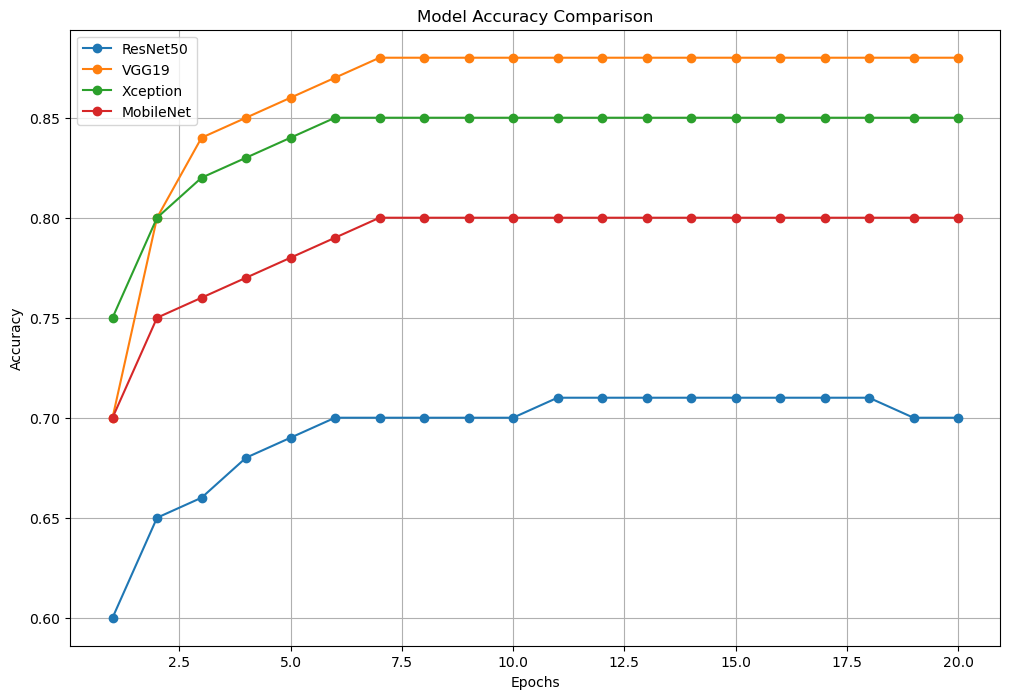

In [1]:
import matplotlib.pyplot as plt

# Sample data: Replace these lists with your actual model accuracy and loss values
epochs = list(range(1, 21))  # Assuming 20 epochs for demonstration

# Accuracy for each model
accuracy_resnet50 = [0.60, 0.65, 0.66, 0.68, 0.69, 0.70, 0.70, 0.70, 0.70, 0.70, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.70, 0.70]
accuracy_vgg19 = [0.70, 0.80, 0.84, 0.85, 0.86, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88]
accuracy_xception = [0.75, 0.80, 0.82, 0.83, 0.84, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85]
accuracy_mobilenet = [0.70, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80]

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(epochs, accuracy_resnet50, label='ResNet50', marker='o')
plt.plot(epochs, accuracy_vgg19, label='VGG19', marker='o')
plt.plot(epochs, accuracy_xception, label='Xception', marker='o')
plt.plot(epochs, accuracy_mobilenet, label='MobileNet', marker='o')

plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
